In [75]:
import numpy as np

import plotting
from collections import defaultdict

deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

"""
Number cards (2-7): +1 point.
Number cards (8-9): 0 points (no effect).
Number cards (10-Ace): -1 point.
Face cards (Jacks, Queens, and Kings): -1 point.
Ace: 0 points (no effect).
"""
#deck = [1,1,1,1,1,0,0,-1,-1,-1,-1,0]

class BlackJack(object):
    """Create an environment of a Black Jack Game
    dealer = list - dealer list card in his deck
    player = list - player list card in his deck
    done = bool - True if the game is done, and False otherwise
    this class only can be accessed from act(), reset(), state()
    act() = PARAMS : 1 if hit, 0 if stick
            RETURN : (state), done_status, reward
    reset() = PARAMS : None
              RETURN : None
    state() = PARAMS : None
             RETURN : (state)
    (state) is a tuple of player score, dealers score, usable ace condition
    Black Jack Refferences:
    [1] https://webdocs.cs.ualberta.ca/~sutton/book/ebook/node51.html (Example 5.1)
    [2] http://www.bicyclecards.com/how-to-play/blackjack/
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.dealer = [self.draw()]
        self.player = [self.draw()]
        self.done = False

    def natural(self,hand): # check if he got natural/blackjack condition
        return sorted(hand)==[1,10]

    def draw(self): # get one card
        return np.random.choice(deck)

    def usable(self, hand): # check if he got usable ace condition
        return 1 in hand and sum(hand) + 10 <= 21

    def busted(self, hand): # check if he got busted
        return self.sum_hand(hand) > 21

    def sum_hand(self, hand):
        if self.usable(hand):
            return sum(hand) + 10
        else:
            return sum(hand)

    def state(self):
        return self.sum_hand(self.player), self.sum_hand(self.dealer), self.usable(self.player)

    def act(self, hit):
        if not self.done:
            if hit:
                self.hit()
                if self.busted(self.player):
                    self.done = True
                    return self.state(), self.done, -1
                else:
                    return self.state(), self.done, 0
            else:
                return self.stick()

    def hit(self):
        self.player.append(self.draw())

    def stick(self):
        self.done = True

        # Dealer doing hit while his score below 17
        # see refference [2]
        while self.sum_hand(self.dealer) < 17:
            self.dealer.append(self.draw())

        # player'll never get busted in here so just sum it
        player_score = self.sum_hand(self.player)

        dealer_score = -1 if self.busted(self.dealer) else self.sum_hand(self.dealer)

        if self.natural(self.player) and self.natural(self.dealer):
            reward = 1
        elif self.natural(self.player):
            reward = 1.5
        elif dealer_score > player_score:
            reward = -1
        elif dealer_score < player_score:
            reward = 1
        else:
            reward = 0

        return self.state(), self.done, reward


env = BlackJack()

TEMPORAL-DIFFERENCE CONTROL A.K.A SARSA OPTIMIZE THE POLICY AND Q-VALUE


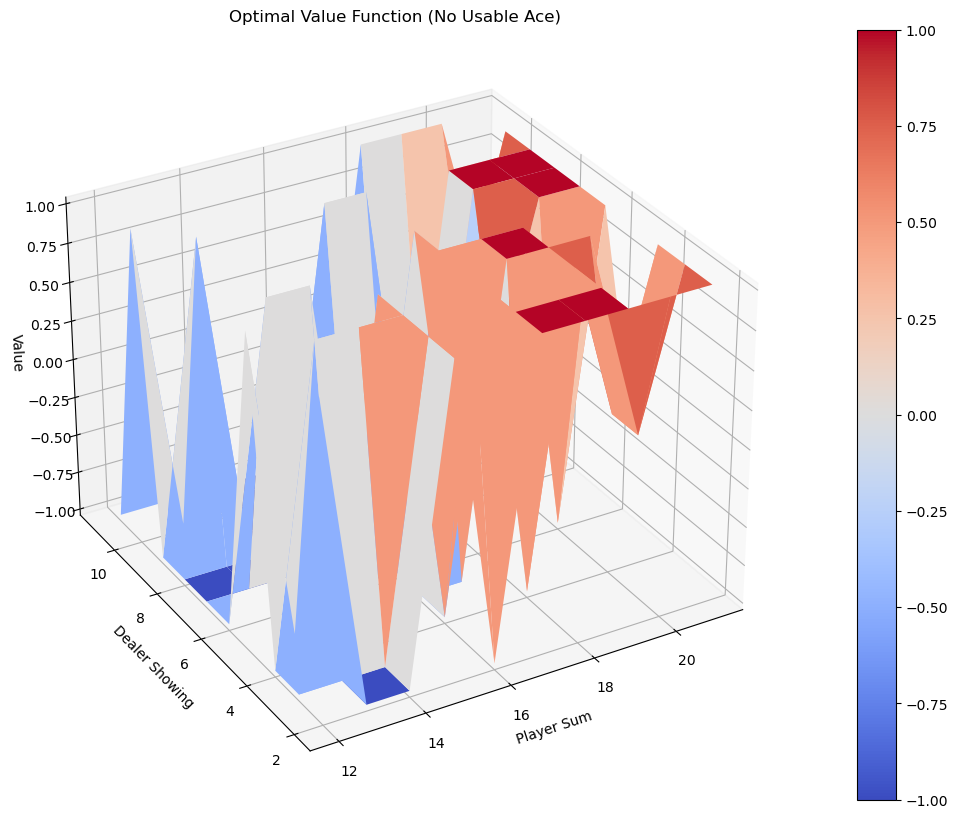

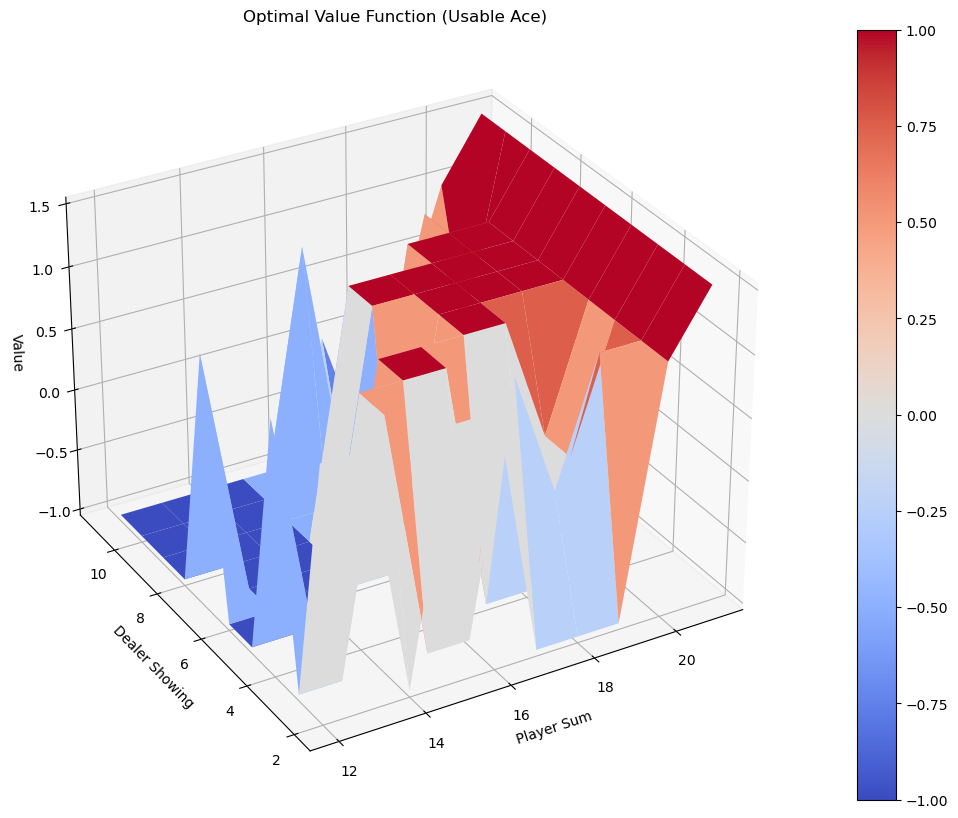

In [79]:
def policy_epsilon(Q, epsilon, state):
    """Policy-epsilon :
	   - always hit when player score < 12
	   - otherwise:
		   - epsilon probability choosing random action
		   - 1-epsilon probability choosing action wich has maximum Q value
    """

    # Greedy choose hit when score < 12
    if state[0] < 12:
        return [0.0, 1.0]

    if np.random.rand() <= epsilon:
        # Explore
        return np.array([0.5, 0.5])
    else:
        # Exploit
        best_action = np.argmax(Q[state])
        A = np.zeros(2)
        A[best_action] = 1
        return A

# td_control a.k.a SARSA
def td_control(policy, n_episodes, alfa=1.0, epsilon=0.1, discount=1.0, env=env):

    # Make a dictionary with deafult value 0.0
    Q = defaultdict(lambda: [0.0, 0.0])

    for e in range(n_episodes):

        env.reset()
        now_state = env.state()
        terminate = False

        # Chosen action
        act_prob = policy(Q, epsilon, now_state)
        # Das wird random gemacht, weil die actions [1, 0] sind, wenn die Policy eploited wird und [0.5, 0.5], wenn explored werden soll.
        action = np.random.choice(np.arange(len(act_prob)), p=act_prob) 
        # Generate one episode
        while not terminate:

            # Take action
            next_state, done, reward = env.act(action)

            # Get next action
            next_act_prob = policy(Q, epsilon, next_state)
            next_action = np.random.choice(np.arange(len(next_act_prob)),
                                                           p=next_act_prob)

            # Not waiting to generate one episode for TD update
            delta = reward + discount * Q[next_state][next_action] - Q[now_state][action]
            Q[now_state][action] = Q[now_state][action] + alfa * delta

            # Move to the next state
            now_state = next_state
            action = next_action

            if done:
                terminate = True

    return Q, policy

"""Block code below optimize Q by a policy and return Q and plotted V-value
"""
print("TEMPORAL-DIFFERENCE CONTROL A.K.A SARSA OPTIMIZE THE POLICY AND Q-VALUE")

Q, policy = td_control(policy_epsilon, n_episodes=100000)

# For plotting purpose, find V-value from Q-Value
V = defaultdict(float)
for state, actions in Q.items():
    action_value = max(actions)
    V[state] = action_value

# Delete state with player score below 12 and dealer more than 11
# to make it same with example
new_V = defaultdict(float)
for key, data in V.items():
    if key[0] >= 12 and key[1]<=11 and key[0]<=21:
        new_V[key] = data

# Using plotting library from Denny Britz repo
plotting.plot_value_function(new_V, title="Optimal Value Function")


In [78]:
def plot_policy(Q, title="Policy"):
    # Find the min and max values for player and dealer to know the dimensions of
    min_x = min(k[0] for k in Q.keys())
    max_x = max(k[0] for k in Q.keys())
    min_y = min(k[1] for k in Q.keys())
    max_y = max(k[1] for k in Q.keys())

    print(title)
    print("   ", end="")
    print([x for x in range(min_y-1, max_y)]) # -1 for the ace
    for player in range(max_x, min_x-1, -1): # reversed order
        print(str(player) + ":", end=" ")
        for dealer in range(min_y-1, max_y): # -1 for the ace
            key = (player, dealer, False)
            key_ace = (player, dealer, True)
            policy = Q[key]
            policy_ace = Q[key_ace]
            if policy == True:
                print("1", end="  ")
            elif policy_ace == True:
                print("2", end="  ")
            else:
                print(" ", end="  ")
            #print(int(policy), end=" ")
        print()

        

In [73]:
# For plotting purpose, find V-value from Q-Value
V = defaultdict(float)
i = 0
print("len(Q)", len(Q))

policy_hitting = defaultdict(bool)
policy_hitting_ace = defaultdict(bool)
for state, actions in Q.items():
    if state[2] == True:
        # usable ace
        if actions[0] == 1.0:
            policy_hitting_ace[state] = False
        else:
            policy_hitting_ace[state] = True
    else:
        # no usable ace
        if actions[0] == 1.0:
            policy_hitting[state] = False
        else:
            policy_hitting[state] = True


# Delete state with player score below 12 and dealer more than 11
# to make it same with example
new_policy_hitting = defaultdict(bool)
for key, data in policy_hitting.items():
    if key[0] >= 12 and key[1]<=11 and key[0]<=19:
        new_policy_hitting[key] = data
new_policy_hitting_ace = defaultdict(bool)
for key, data in policy_hitting_ace.items():
    if key[0] >= 12 and key[1]<=11 and key[0]<=19:
        new_policy_hitting_ace[key] = data

print("len after ace:", len(new_policy_hitting_ace))
print("len after:", len(new_policy_hitting))

print()
plot_policy(new_policy_hitting, title="Policy no usuable ace")
print()
plot_policy(new_policy_hitting_ace, title="Policy usuable ace")

len(Q) 610
len after ace: 80
len after: 80

Policy no usuable ace
   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
19:             1              1  
18:    1     1     1     1  1     
17:    1     1  1  1  1  1     1  
16:             1  1     1  1  1  
15:       1     1  1  1  1  1  1  
14:    1  1        1     1  1  1  
13:    1  1  1  1     1     1  1  
12:    1           1  1     1     

Policy usuable ace
   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
19:             2        2        
18:                   2  2  2  2  
17:       2           2  2  2  2  
16:    2  2     2  2  2  2  2  2  
15:       2  2  2        2  2  2  
14:       2           2     2     
13:       2  2     2  2  2     2  
12:    2  2  2        2  2     2  


TEMPORAL-DIFFERENCE EVALUATE POLICY_0


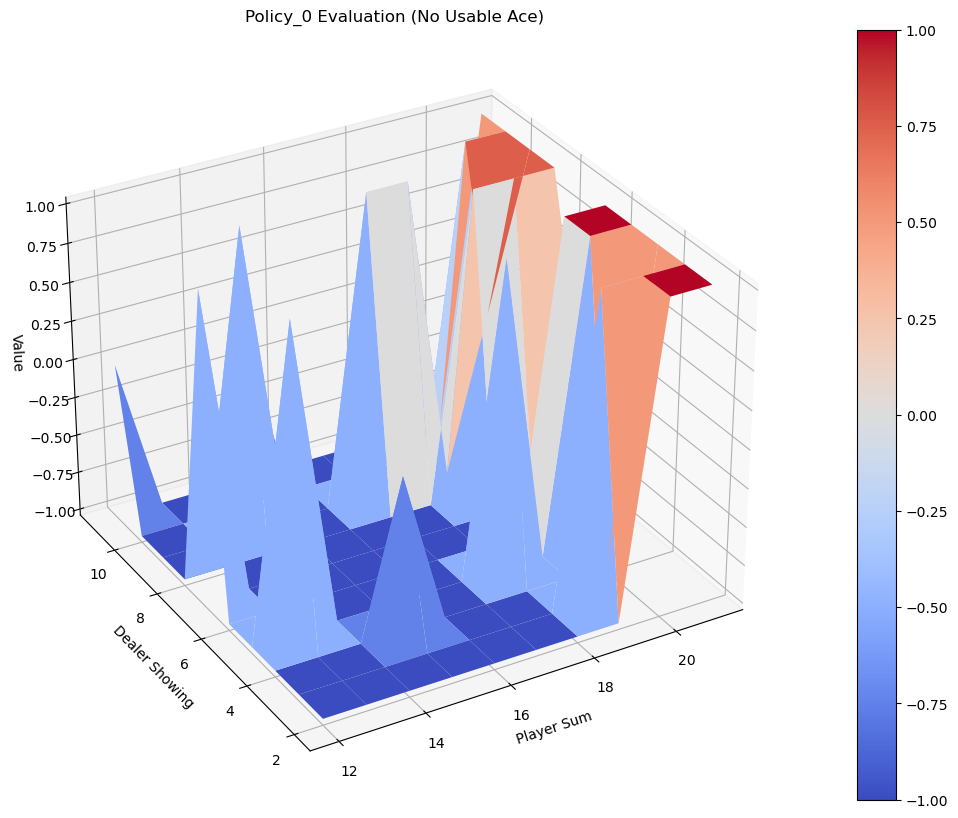

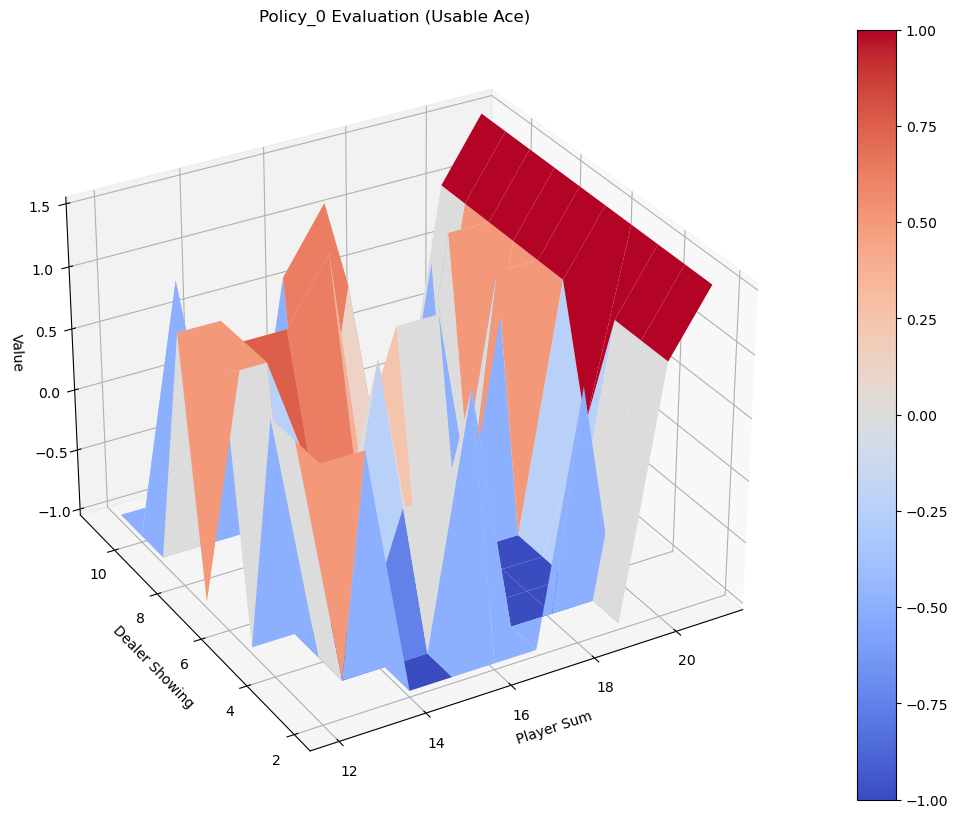

In [3]:
def policy_0(pl_score, de_score, use_ace):
    """Policy-0 : always "hit" except we got score >= 20
    """

    # Using probability instead of actual act number for consistency
    return np.array([1.0, 0.0]) if pl_score >= 20 else np.array([0.0, 1.0])

def td_prediction(policy, n_episodes, alfa=1.0, discount=1.0, env=env):

    # Make a dictionary with deafult value 0.0
    V = defaultdict(float)

    for e in range(n_episodes):
        env.reset()
        now_state = env.state()
        terminate = False

        # Running an episode
        while not terminate:
            # Chosen action
            act_prob = policy(*now_state)
            action = np.random.choice(np.arange(len(act_prob)), p=act_prob)

            # Take action
            next_state, done, reward = env.act(action)

            # Not waiting to generate one episode for TD update
            delta = reward + discount * V[next_state] - V[now_state]
            V[now_state] = V[now_state] + alfa * delta

            # Move to the next state
            now_state = next_state

            if done:
                terminate = True

    return V

"""Block code below evaluate a policy and return a plotted V-value
"""
print("TEMPORAL-DIFFERENCE EVALUATE POLICY_0")

V = td_prediction(policy_0, n_episodes=10000)

# Delete state with player score below 12 to make it same with example
# Because we call V[next_state] in the end, to make the same plot
# we should delete some keys
new_V = defaultdict(float)
for key, data in V.items():
    if key[0] >= 12 and key[1]<=11 and key[0]<=21:
        new_V[key] = data

# Using plotting library from Denny Britz repo
plotting.plot_value_function(new_V, title="Policy_0 Evaluation")

In [ ]:
"""Block code below using optimized Q-value and policy before,
Then run it on a game
"""
print("SIMULATE THE OPTIMIZED POLICY AND Q-VALUE")

def print_state( pl_score, de_score, use_ace, reward=0):
    if env.done:
        print("== Game Over ==")
        print("Reward: {}".format(reward))
    print("Player: {} | Dealer: {} | Usable Ace: {}".format(
                pl_score, de_score, use_ace))

    # You shouldn't print deck list
    print("Player Deck: {}".format(env.player))
    print("Dealer Deck: {}".format(env.dealer))

def act(hit, env=env):
    state, done, reward = env.act(hit)
    pl_score, de_score, use_ace = state
    print_state(pl_score, de_score, use_ace, reward)
    return state, done, reward

def reset(env=env):
    env.reset()
    pl_score, de_score, use_ace = env.state()
    print_state(pl_score, de_score, use_ace)
    return pl_score, de_score, use_ace

state = reset()
done = False
while not done:
    print("")
    action = 1 if state[0]<12 else np.argmax(Q[state])
    print("action: HIT" if action==1 else "action: STICK")
    state, done, reward = act(action)